# Основные функции

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


WRIST_CUT_RATIO = 0.98
RADIUS_EXPANSION = 1.95
MIN_POINT_DISTANCE = 16
LEN_OF_F = 0.18
EROSION_KERNEL_SIZE = 5
DILATION_KERNEL_SIZE = 5

def remove_wrist_area(input_image, cut_ratio=WRIST_CUT_RATIO):
    height = input_image.shape[0]
    return input_image[:int(height * cut_ratio), :]

def extract_hand_outline(input_image):
    grayscale = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(grayscale, 50, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    original_mask = binary_mask.copy()
    
    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (EROSION_KERNEL_SIZE, EROSION_KERNEL_SIZE))
    eroded_mask = cv2.erode(binary_mask, erosion_kernel, iterations=3)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded_mask, connectivity=8)
    if num_labels > 1:
        areas = stats[1:, cv2.CC_STAT_AREA]
        max_area_idx = np.argmax(areas) + 1
        largest_component_mask = (labels == max_area_idx).astype(np.uint8) * 255
    else:
        largest_component_mask = eroded_mask
    
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (DILATION_KERNEL_SIZE, DILATION_KERNEL_SIZE))
    restored_mask = cv2.dilate(largest_component_mask, dilation_kernel, iterations=3)
    
    final_mask = cv2.bitwise_and(restored_mask, original_mask)
    
    outline_list, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(outline_list) > 0:
        main_outline = max(outline_list, key=cv2.contourArea)
    else:
        outline_list, _ = cv2.findContours(original_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        main_outline = max(outline_list, key=cv2.contourArea)
        final_mask = original_mask
    
    return main_outline, final_mask

def locate_palm_center(hand_outline, binary_mask):
    mask_filled = np.zeros_like(binary_mask)
    cv2.drawContours(mask_filled, [hand_outline], -1, 255, -1)
    
    distance_map = cv2.distanceTransform(mask_filled, cv2.DIST_L2, 5)
    _, radius_base, _, center_point = cv2.minMaxLoc(distance_map)
    
    return center_point, radius_base

def compute_circle_crossings(hand_outline, palm_center, expanded_radius):
    outline_coordinates = hand_outline[:, 0, :]
    crossing_points = []
    
    for idx in range(len(outline_coordinates)):
        point_a = outline_coordinates[idx]
        point_b = outline_coordinates[(idx + 1) % len(outline_coordinates)]
        dist_a = np.linalg.norm(point_a - palm_center)
        dist_b = np.linalg.norm(point_b - palm_center)
        
        if (dist_a - expanded_radius) * (dist_b - expanded_radius) < 0:
            interpolation_factor = (expanded_radius - dist_a) / (dist_b - dist_a)
            crossing_point = point_a + interpolation_factor * (point_b - point_a)
            crossing_points.append(crossing_point)
    
    return np.array(crossing_points).astype(int)

def remove_nearby_points(point_array, min_dist=MIN_POINT_DISTANCE):
    if len(point_array) == 0:
        return point_array
    
    indices_to_remove = set()
    for i in range(len(point_array)):
        for j in range(i + 1, len(point_array)):
            if np.linalg.norm(point_array[i] - point_array[j]) < min_dist:
                indices_to_remove.add(i)
                indices_to_remove.add(j)
    
    return np.array([pt for idx, pt in enumerate(point_array) if idx not in indices_to_remove])

def find_maximum_angle_span(point_set, center_location):
    if len(point_set) < 2:
        return 0
    
    angles = []
    for point in point_set:
        angle = np.arctan2(point[1] - center_location[1], point[0] - center_location[0])
        if angle < 0:
            angle += 2 * np.pi
        angles.append(angle)
    
    angles = np.array(angles)
    sorted_indices = np.argsort(angles)
    sorted_angles = angles[sorted_indices]
    
    max_gap = 0
    max_gap_start_idx = 0
    
    for i in range(len(sorted_angles)):
        next_i = (i + 1) % len(sorted_angles)
        
        if next_i == 0:
            gap = (2 * np.pi - sorted_angles[i]) + sorted_angles[next_i]
        else:
            gap = sorted_angles[next_i] - sorted_angles[i]
        
        if gap > max_gap:
            max_gap = gap
            max_gap_start_idx = sorted_indices[next_i]
    
    return max_gap_start_idx

def arrange_points_by_angle(point_set, center_location):
    if len(point_set) == 0:
        return point_set
    
    start_idx = find_maximum_angle_span(point_set, center_location)
    
    angles = []
    for point in point_set:
        angle = np.arctan2(point[1] - center_location[1], point[0] - center_location[0])
        if angle < 0:
            angle += 2 * np.pi
        angles.append(angle)
    
    angles = np.array(angles)
    start_angle = angles[start_idx]
    
    relative_angles = []
    for i, angle in enumerate(angles):
        relative_angle = angle - start_angle
        if relative_angle < 0:
            relative_angle += 2 * np.pi
        relative_angles.append(relative_angle)
    
    sorted_indices = np.argsort(relative_angles)
    return point_set[sorted_indices]

def transform_arc_to_line(crossing_points, center_location, expanded_radius):
    if len(crossing_points) < 2:
        return []
    
    angles = []
    for point in crossing_points:
        angle = np.arctan2(point[1] - center_location[1], point[0] - center_location[0])
        if angle < 0:
            angle += 2 * np.pi
        angles.append(angle)
    
    angles = np.array(angles)
    start_angle = angles[0]
    cumulative_distances = [0.0]
    
    for i in range(1, len(angles)):
        angle_diff = angles[i] - start_angle
        if angle_diff < 0:
            angle_diff += 2 * np.pi
        
        arc_length = angle_diff * expanded_radius
        cumulative_distances.append(arc_length)
    
    max_distance = max(cumulative_distances) if cumulative_distances else 1.0
    if max_distance > 0:
        normalized_distances = [dist / max_distance for dist in cumulative_distances]
    else:
        normalized_distances = cumulative_distances
    
    return normalized_distances

def generate_pose_signature(line_coordinates):
    if len(line_coordinates) == 2:
        return '1+2+3+4+5'
    if len(line_coordinates) >= 9:
        return '1-2-3-4-5'
        
    temp = []
    for i in range(1, len(line_coordinates), 2):
        a = line_coordinates[i] - line_coordinates[i-1]
        temp.append(a)
    
    ans = []
    for i in range(len(temp)):
        ans.append(int(temp[i] // LEN_OF_F) + 1)
        if ans[-1] == 0:
            ans[-1] = 1
    
    if len(ans) == 2:
        ans[0] = 4

    ones = 0
    for i in range(len(ans)):
        if ans[i] == 1:
            ones += 1
        else:
            index = i
    if ones == len(ans) - 1:
        ans[index] = 5 - ones

    if sum(ans) < 5:
        index = temp.index(max(temp))
        ans[index] += 5 - sum(ans)
    
    result_code = ''
    idx = 1
    for i in range(len(ans)):
        result_code += str(idx)
        idx += 1
        if idx == 6:
            break
        for j in range(1, ans[i], 1):
            result_code += '+' + str(idx)
            idx += 1
            if idx == 6:
                break
        if idx == 6:
            break
        result_code += '-'
    
    return result_code

def process_hand_pose(image_file_path, 
                     wrist_cut_ratio=WRIST_CUT_RATIO,
                     radius_expansion=RADIUS_EXPANSION,
                     save_to_file=True):
    
    source_image = cv2.imread(image_file_path)
    if source_image is None:
        raise ValueError(f"Невозможно загрузить изображение: {image_file_path}")
    
    processed_image = remove_wrist_area(source_image, wrist_cut_ratio)
    hand_outline, binary_mask = extract_hand_outline(processed_image)

    palm_center, base_radius = locate_palm_center(hand_outline, binary_mask)
    expanded_radius = base_radius * radius_expansion
    
    crossing_points = compute_circle_crossings(hand_outline, palm_center, expanded_radius)
    filtered_crossings = remove_nearby_points(crossing_points)
    
    sorted_crossings = arrange_points_by_angle(filtered_crossings, palm_center)
    
    linear_positions = transform_arc_to_line(sorted_crossings, palm_center, expanded_radius)
    
    pose_code = generate_pose_signature(linear_positions)
    if save_to_file:
        import os
        filename = os.path.basename(image_file_path)
        save_results_to_file(pose_code, sorted_crossings, filename)

    print(f"Код позы: {pose_code}")
    
    return {
        'processed_image': processed_image,
        'original_image': source_image,
        'binary_mask': binary_mask,
        'palm_center': palm_center,
        'base_radius': base_radius,
        'expanded_radius': expanded_radius,
        'crossing_points': sorted_crossings,
        'linear_positions': linear_positions,
        'pose_code': pose_code
    }

def display_analysis_results(analysis_result):
    processed_img = analysis_result['processed_image']
    palm_center = analysis_result['palm_center']
    base_radius = analysis_result['base_radius']
    expanded_radius = analysis_result['expanded_radius']
    crossing_points = analysis_result['crossing_points']
    pose_signature = analysis_result['pose_code']
    linear_positions = analysis_result['linear_positions']
    
    output_image = processed_img.copy()
    
    cv2.circle(output_image, tuple(palm_center), int(base_radius), (0, 180, 0), 2)
    cv2.circle(output_image, tuple(palm_center), int(expanded_radius), (180, 0, 180), 2)
    
    for idx, (x, y) in enumerate(crossing_points):
        cv2.circle(output_image, (x, y), 6, (255, 100, 0), -1)
        cv2.putText(output_image, str(idx+1), (x+12, y-8), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    cv2.putText(output_image, f"Pose Code: {pose_signature}", (15, 35), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 3, cv2.LINE_AA)
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(analysis_result['original_image'], cv2.COLOR_BGR2RGB))
    plt.title("Исходное изображение", fontsize=12)
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(analysis_result['binary_mask'], cmap='gray')
    plt.title("Бинарная маска", fontsize=12)
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Результат анализа: {pose_signature}", fontsize=12)
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    if linear_positions:
        plt.scatter(linear_positions, [0] * len(linear_positions), s=120, c='orange', alpha=0.8, edgecolors='black')
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.4, 0.4)
        plt.xlabel("Нормализованная позиция", fontsize=10)
        plt.title("Распределение точек (нормализованные координаты)", fontsize=12)
        plt.grid(True, alpha=0.4)
        
        for idx, pos in enumerate(linear_positions):
            plt.annotate(f'{idx+1}', (pos, 0), xytext=(pos, 0.15), 
                        ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


def save_results_to_file(pose_code, crossing_points, filename, output_file="Results.txt"):
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(pose_code + '\n')
    
    print(f"Результаты сохранены в файл: {output_file}")
    

# Запуск программы

Введите путь к избражению, которое необходимо обработать

In [2]:
image_path = "Training/286.tif" 

Если необходимо сохрнаить результаты в файле `Results.txt`, поставьте значение `True`, иначе - `False`.

In [3]:
is_save = False

Запуск программы:

Код позы: 1-2-3+4+5


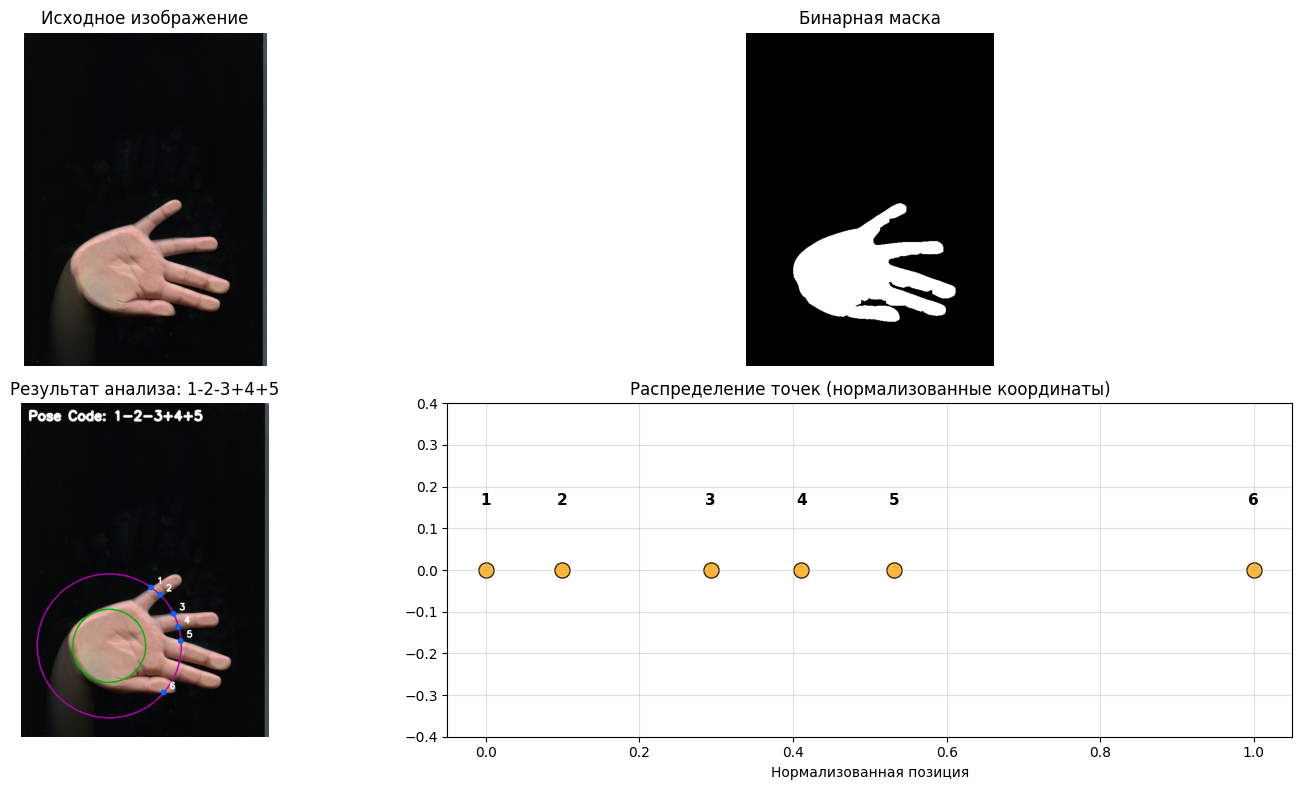

In [4]:
result = process_hand_pose(image_path, save_to_file=is_save)
display_analysis_results(result)